In [1]:
import sys
sys.path.append('C:/Users/smithlab/Documents/Aaron/Modules/')
import visa
import numpy as np
from struct import unpack
from matplotlib import pyplot as plt
import stage_control as sc
import scipy.constants

rc = {"font.size" : 17,
      "font.family" : "Times New Roman", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)

def acquire(obj, channel):
    try:
        # obj.write('*RST')
        obj.write("DATA:SOURCE " + channel)
        obj.write('DATA:WIDTH 1')
        obj.write('DATA:ENC RPB')
        obj.timeout = 25000
        ymult = float(obj.query('WFMPRE:YMULT?'))
        yzero = float(obj.query('WFMPRE:YZERO?'))
        yoff = float(obj.query('WFMPRE:YOFF?'))
        xincr = float(obj.query('WFMPRE:XINCR?'))
        xdelay = float(obj.query('HORizontal:POSition?'))
        obj.write('CURVE?')
        data = obj.read_raw()
        headerlen = 2 + int(data[1])
        header = data[:headerlen]
        ADC_wave = data[headerlen:-1]
        ADC_wave = np.array(unpack('%sB' % len(ADC_wave),ADC_wave))
        Volts = (ADC_wave - yoff) * ymult  + yzero
        Time = np.arange(0, (xincr * len(Volts)), xincr)-((xincr * len(Volts))/2-xdelay)
        return Time,Volts
    except IndexError:
        return 0,0

## Parameters

In [2]:
C = scipy.constants.c
f = 11E9
lam = C/f
k = 2*np.pi*f/C
IFBW = 1000

xrange = 1000 # x length of stage, mm
yrange = 1000 # y length of stage, mm
speedmms = 25

## Initialize instruments

In [ ]:
## Stage
g = sc.stage_start('169.254.225.173')
sc.stage_home(g,speedmms)

## Oscilloscope
rm = visa.ResourceManager()
rm.list_resources()
scope = rm.open_resource('USB0::0x0699::0x0368::C019640::0::INSTR')
scope_name = scope.query('*IDN?')
print(scope_name)
scope.write('*RST')
scope.timeout = 25000

## Move to new origin

In [ ]:
center_x = -xrange/2;
center_y = -yrange/2;
pos_x = -80;  # adjust to change x zero position
pos_y = -130;  # adjust to change y zero position

sc.move_to_absolute(g,speedmms,0,0,center_x+pos_x,center_y+pos_y)

## Zero axes

In [ ]:
defZeroInXsteps, defZeroInYsteps = sc.zero_axes(g);

## Define source positions

In [3]:
x_source = np.linspace(-.1, .1, 10)
y_source = 0
z_source = 0.13

## Take measurements

In [ ]:
for i in range(x_source.size):
    
    sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,x_source[i]*1000,y_source*1000)
    time, i_temp = acquire(scope, '1')
    time, q_temp = acquire(scope, '2')

    if i == 0:
        i_array = np.empty((x_source.size, time.size), dtype=float)
        q_array = np.empty((x_source.size, time.size), dtype=float)

    i_array[i,:] = i_temp
    q_array[i,:] = q_temp

v_exp = np.mean(i_array.astype(np.complex128) + 1j*q_array.astype(np.complex128), axis=1)

## Compare with theory

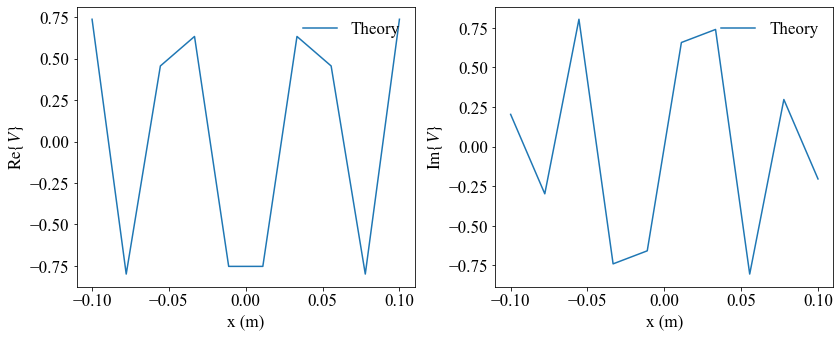

In [11]:
x1 = -.07
y1 = 0
z1 = 0

x2 = .07
y2 = 0
z2 = 0

def green(x1, y1, z1, x2, y2, z2, k):
    R = np.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
    return np.exp(-1j*k*R)/R

v_theory = np.conjugate(green(x_source, y_source, z_source, x1, y1, z1, k)) * green(x_source, y_source, z_source, x2, y2, z2, k)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(x_source, np.real(v_theory)/np.max(np.abs(v_theory)), label='Theory')
ax1.plot(f, np.real(v_exp)/np.max(np.abs(v_exp)))
ax1.set_xlabel('x (m)')
ax1.set_ylabel(r'$\mathrm{Re}\{V\}$')
ax1.legend(frameon=False, loc='upper right')
ax2.plot(x_source, np.imag(v_theory)/np.max(np.abs(v_theory)), label='Theory')
ax2.plot(f, np.imag(v_exp)/np.max(np.abs(v_exp)))
ax2.set_xlabel('x (m)')
ax2.set_ylabel(r'$\mathrm{Im}\{V\}$')
ax2.legend(frameon=False, loc='upper right')
# ax1.plot(f, np.abs(v_theory)/np.max(np.abs(v_theory)))
# ax1.plot(f, np.abs(v_exp)/np.max(np.abs(v_exp)))
# ax2.plot(f, np.angle(v_theory))
# ax2.plot(f, np.angle(v_exp))
# ax2.set_xlim(9.9E9, 10.1E9)
plt.tight_layout()
plt.show()

## Clean up communications

In [ ]:
sc.close_connection(g)
scope.close()